# Time Series Forecasting using Arimax Model


### Loading the Libraries and the Dataset

In [244]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

data = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))


In [245]:
data.head(10)

,Index,Price,Production,Withdrawals,GlobalPrice,ExchangeRate,TempMax,TempAvg,Precipitation
Month,,,,,,,,,
2014-09-01,1,51.51,537770,1418420,0.1470,44.08,28,27,456.59
2014-10-01,2,51.46,1623075,1355836,0.1648,44.80,29,27,436.73
2014-11-01,3,51.28,2277043,2156729,0.1588,44.95,29,28,265.32
2014-12-01,4,51.65,2223994,1663150,0.1499,44.69,28,27,182.00
2015-01-01,5,51.19,2259613,1714490,0.1506,44.60,28,27,82.83
2015-02-01,6,51.25,3124172,1777931,0.1451,44.22,28,27,21.90
2015-03-01,7,51.15,3939203,2154934,0.1284,44.45,30,28,5.80
2015-04-01,8,51.95,2405134,1679034,0.1294,44.41,31,29,67.44
2015-05-01,9,52.88,1711529,2031509,0.1270,44.61,30,29,186.11


#### Steps for ARIMAX
1. The time series data must be stationary
2. Provide a forecast for the exogeneous variables
3. Train-Test split
4. Error metric

Start by forecasting each variable using ARIMA


##### Price

The price is going to be the dependent variable

<Axes: xlabel='Month'>

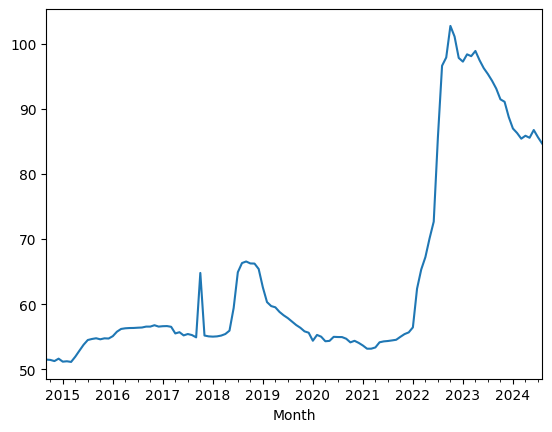

In [246]:
data['Price'].plot()

Initial ADF Test

In [247]:
def ADF_test(data):
    p = adfuller(data)[1]
    print (f'P-value: {p} < 0.05')
    if p < 0.05:
        print('Series is stationary')
    else:
        print('Series is not stationary')

In [248]:
ADF_test(data['Price'])

P-value: 0.663961545174224 < 0.05
Series is not stationary


Since the data is not stationary, Let's perform differencing

In [249]:
data['Price_diff'] = data['Price'].diff()
data['Price_diff'].dropna()

data_2 = data[['Price_diff' ,'Price']]
data_2.head(12)

,Price_diff,Price
Month,,
2014-09-01,NaN,51.51
2014-10-01,-0.05,51.46
2014-11-01,-0.18,51.28
2014-12-01,0.37,51.65
2015-01-01,-0.46,51.19
2015-02-01,0.06,51.25
2015-03-01,-0.10,51.15
2015-04-01,0.80,51.95
2015-05-01,0.93,52.88


**How Differencing works**

differenced_month = month_1 - month_2
difference = {2014-09} - {2014-10}
difference = 51.51 - 

Look at the behaviour of the Price after differencing

<Axes: xlabel='Month'>

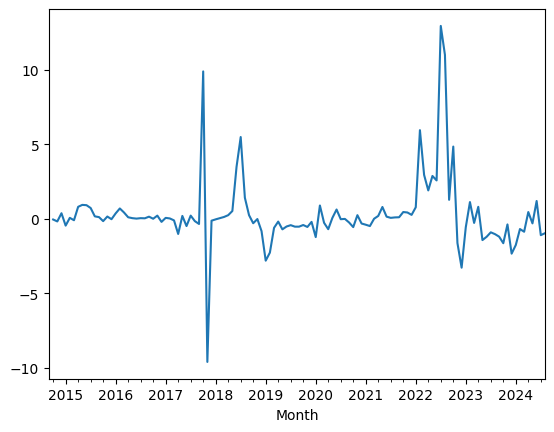

In [250]:
data['Price_diff'].plot()

In [251]:
ADF_test(data['Price_diff'].dropna())

P-value: 5.67356265349366e-06 < 0.05
Series is stationary


#### Train-Test split
80% of the data will be used for training, 20% for testing, then proceed to forecasting once the test data is closed to the actual data

In [252]:
n = int(len(data_2) * 0.8)
train = data_2.iloc[0:n]
test = data_2.iloc[n:len(data_2)]

print(f'Train size: {len(train)}')
print(f'Test size: {len(test)}')

Train size: 96
Test size: 24


Find the best `p,d,q` order

In [253]:
import itertools
import numpy as np 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p, d, q))
best_pdq = None
lowest_rmse = float("inf")

for param in pdq:
    try:
        model = SARIMAX(train['Price'], order=param, seasonal_order=(0,0,0,0)).fit(disp=0)
        predictions = model.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test['Price'], predictions))
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            best_pdq = param
    except:
        continue
print(f'Best parameters: {best_pdq} with RMSE: {lowest_rmse}')

Best parameters: (0, 1, 0) with RMSE: 6.86773130905202


In [254]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

def determine_best_arima_order(data, max_p=3, max_d=2, max_q=3):
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q)).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        best_model = model
                except:
                    continue
    
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order, best_model

# Example usage:
best_order, best_model = determine_best_arima_order(train['Price'])

Best ARIMA order: (0, 2, 1) with AIC: 427.52912539745563


In [255]:
model = ARIMA(train['Price'], order=(0,1,1)).fit()

import warnings
warnings.filterwarnings("ignore")

In [256]:
predictions = model.predict(start=len(train), end=len(train) + len(data) - 1)
forecast = model.forecast(steps=len(test))

In [257]:
predictions.head()

2022-09-01    98.452517
2022-10-01    98.452517
2022-11-01    98.452517
2022-12-01    98.452517
2023-01-01    98.452517
Freq: MS, Name: predicted_mean, dtype: float64

In [258]:
forecast.head()

2022-09-01    98.452517
2022-10-01    98.452517
2022-11-01    98.452517
2022-12-01    98.452517
2023-01-01    98.452517
Freq: MS, Name: predicted_mean, dtype: float64

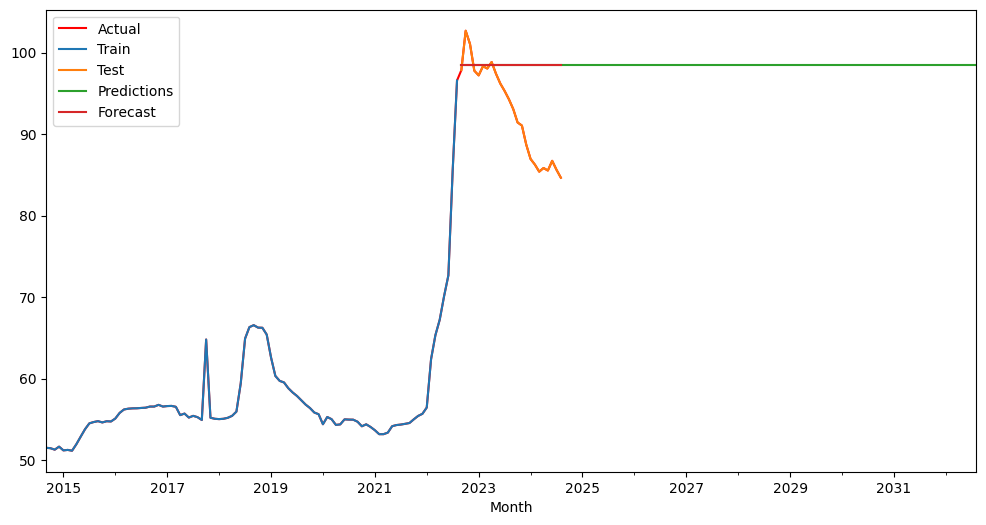

In [259]:
data['Price'].plot(label='Actual', color='red')
train['Price'].plot(label='Train', figsize=(12, 6))
test['Price'].plot(label='Test')
predictions.plot(label='Predictions')
forecast.plot(label='Forecast')
plt.legend()

predict outside

In [263]:
final_model = ARIMA(data['Price'], order=(0,1,1)).fit()
final_predictions = final_model.predict(start=len(data), end=len(data) + 12)

<Axes: xlabel='Month'>

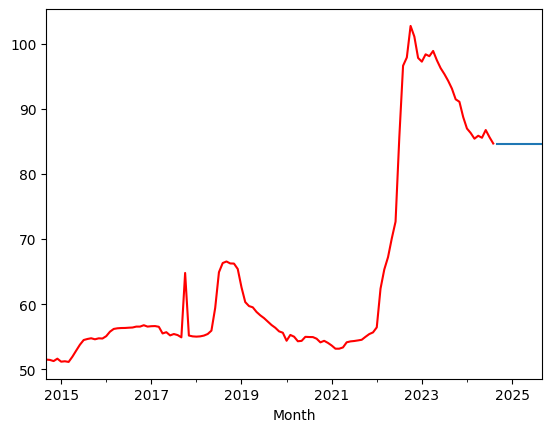

In [264]:
data['Price'].plot(label='Actual', color='red')
final_predictions.plot(label='Final Predictions')

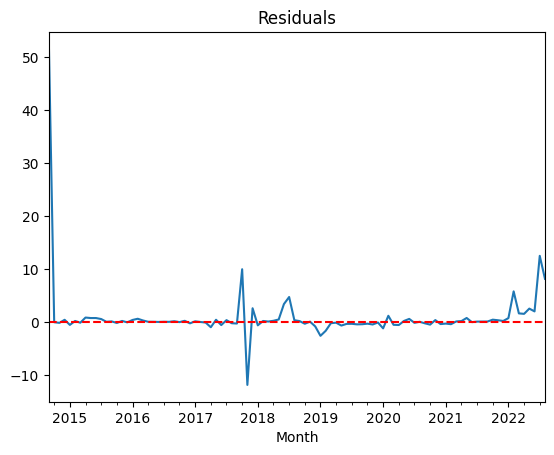

count    96.000000
mean      0.934432
std       5.753138
min     -11.877886
25%      -0.268613
50%       0.062322
75%       0.410939
max      51.510000
dtype: float64


In [265]:
# Calculate residuals
residuals = train['Price'] - model.fittedvalues

# Plot residuals
residuals.plot(title='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Summary statistics of residuals
print(residuals.describe())